#  ATOC5860 Application Lab #3 - eigenfaces
##### Written by Dr. Vineel Yettella (ATOC Ph.D. 2018, now at Apple), with additional commenting from Prof. Kay (CU)
##### last updated February 22, 2023 - works with environment atoc5860env2023clean.yml

### LEARNING GOALS:
1) Complete an EOF analysis using Singular Value Decomposition (SVD). 
2) Provide a qualitative description of the results. What are the eigenvalues, the eigenvectors, and the principal components?  What do you learn from each one about the space-time structure of your underlying dataset?
3) Provide a qualitative description of the results: What are the eigenvalue,the eigenvector, and the principal component?  What do they mean physically? What do you learn from each one about the space-time structure of the underlying dataset?
4) Reconstruct original data using a subset of EOFs: How many EOFs are needed to reconstruct faces?

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you apply EOF analysis to a standard database for facial recognition: the At&t database. 

*“Our Database of Faces, (formerly 'The ORL Database of Faces'), contains a set of face images taken between April 1992 and April 1994 at the lab. The database was used in the context of a face recognition project carried out in collaboration with the Speech, Vision and Robotics Group of the Cambridge University Engineering Department.

There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).”*

The goal is to think a bit “out of the box” of Atmospheric and Oceanic Sciences about potential applications for the methods you are learning in this class.  And also to think about some of the pitfalls of using statistics for facial recognition. Are the faces here representative of all faces?

### Non-exhaustive Questions to guide your analysis:  
#### 1) Execute all code without making any modifications. What do the EOFs (spatial patterns) tell you?  What do the PCs tell you?  How do you interpret what you are finding?

   - EOF patterns in space can have the ability to have a higher influence of the variance explained of the average faces dependent on the prominence of a structure. 
    
    
   - Principal Components (PCs) help us process the large data into a more concise storage method that can still yield or return us to as much of the original information possible (the specific profile shots). From Barnes EQ 50-53 we define the PCs as $Z=XE$ where Z has length M and is the original data. It tells us how much structure explains a given sample.
    
$$
Z = XE \ (EQ \ 50) \\
X = ZE^{T} \ (EQ \ 51) \\
EE^{T} = I \ (EQ \ 53) \\
X = ZE^{T}
$$
    
#### 2) Reconstruct a face.  How many EOFs do you need to reconstruct a face from the database?  Does it depend on the face that it used?

   - According to the Variance Explained plot above, the top 15 eigen faces have the most variance explained before the plot 'flat lines.' This does depend heavily on the face used. If we had chosen a sample of a white male - which is the dominant example in the EOF - less weights would be needed to reconsruct a face. This is because this influences the EOF eigen vectors that have the highest variance explained. A less representative face would take more weights to appropriately reconstruct a face within a 99% correlation to the original image. In the example below I chose to reconstruct a black man. Compared to a white man, this took 279 weights to appropriately reconstruct a face, while a white male took 213 weights. 
   
   - I also went ahead to see how long it would take for a woman to be reconstructed. I expected a similar result like reconstructing a black man although didn't expect the result. Surprisingly it took 186 weights to appropriately reconstruct her (assumption) face within 99% correlation threshold. 
   
#### 3) Food for thought: The database contains 75% white men.  How do you think this database sampling limitation impacts the utility of the database for subjects who are not white men?  What are some parallels that you might draw when analyzing atmospheric and oceanic sciences datasets?  Hint: Think about the limitations of extrapolation beyond the domain where you have data.

   - For this I chose a specficially non-white person to see how the output would change. Overall the face is able to be reconstructed appropriately, but the sample image will likely have less of a variance explained in the overall EOF analysis. 
    
   - Parallels for atmospheric and oceanic sciences definitely hit on representation. To have a more robust EOF analysis, one might want to make sure appropriately variable, but related data, is accomodated into the overall processing of the reconstructed face. We could consider each person to several images of an atmospheric event and the sub images for each event could be that specific day. If we don't have an appropriate representation of possible events it could take more weights to reconstruct an event or it could show something as anomalous when it wouldn't be. 

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
%matplotlib inline

In [136]:
#load faces. Adapted from the AT&T face database
att_faces = np.load('att_faces.npy')
height, width, n_faces = att_faces.shape
print((height, width, n_faces))

(112, 92, 400)


In [138]:
att_faces.shape

(112, 92, 400)

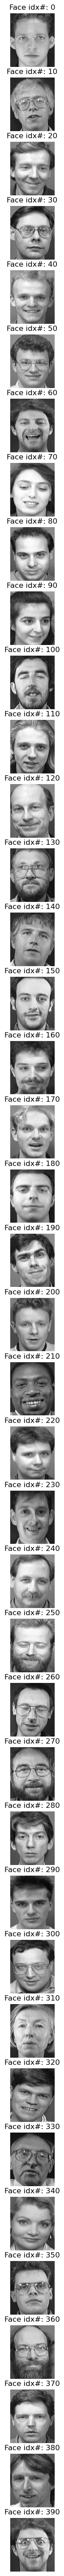

In [49]:
f, ax = plt.subplots(40, 1, figsize=(5,75))
for i,j in enumerate(range(0,400,10)):
    ax[i].imshow(att_faces[:, :, j], cmap='binary_r')
    ax[i].set_title('Face idx#: ' + str(j))
    ax[i].axis('off')

1) Execute all code without making any modifications. What do the EOFs (spatial patterns) tell you?  What do the PCs tell you?  How do you interpret what you are finding?

    - Spatial patterns help highlight prominent features in a specific case (specific face). The principal component.
    
    
    - Principal Components (PCs) help us process the large data into a more concise storage method that can still yield or return us to as much of the original information possible (the specific profile shots). From Barnes EQ 50-53 we define the PCs as $Z=XE$ where Z has length M and is the original data. It tells us how much a given sample looks like a specific EOF structure. 
    
    $$
    Z = XE \ (EQ \ 50) \\
    X = ZE^{T} \ (EQ \ 51) \\
    EE^{T} = I \ (EQ \ 53) \\
    X = ZE^{T}
    $$

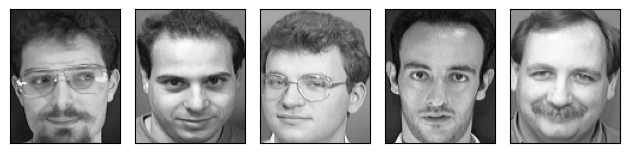

In [10]:
#print a few faces from the database - Look at your data!!
n = 5
fig, axs = plt.subplots(1, n)

random_face_inds = np.random.choice(np.arange(n_faces), n, replace=False)
for i, ax in enumerate(axs):
    ax.imshow(att_faces[:, :, random_face_inds[i]], cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()

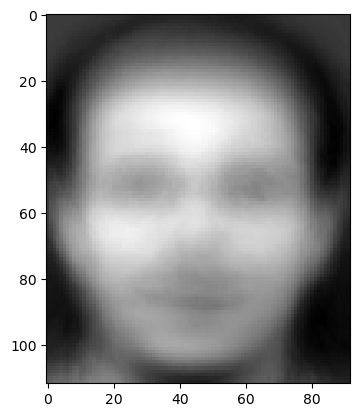

In [11]:
#print the average face
average_face = np.mean(att_faces, axis = 2);
plt.imshow(average_face, cmap = 'gray');

In [13]:
#Construct the data matrix. Samples (different faces) along rows and 
#variables (individual pixels) along columns
print(att_faces.shape)
data_matrix = np.reshape(att_faces, (height*width, n_faces)).T
print(data_matrix.shape)

#Construct anomaly matrix by removing the average face, i.e., 
#by removing the column means from each column of the data_matrix
anomaly_matrix = data_matrix - np.mean(data_matrix, axis=0)
#anomaly_matrix = anomaly_matrix/np.std(anomaly_matrix, axis=0)
[eofs, s, v] = np.linalg.svd(anomaly_matrix.T, full_matrices=False)
print(eofs.shape)

eigenvals = np.square(s)
variance_explained = eigenvals/np.sum(eigenvals)

(112, 92, 400)
(400, 10304)
(10304, 400)


The total variance of the matrix is the sum of the eigen values, so the variance explained is is the eigen values divided by the sum. The plot below shows the top 15 eigen faces that have the highest influence on the average of all the faces together. In this case, it shows which anomalous faces have the highest influence on the overall output of faces put together.

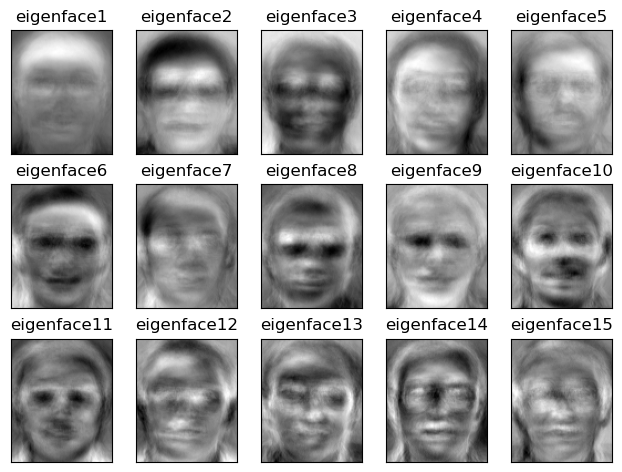

In [14]:
#Plot the top 15 eofs (a.k.a eigenfaces)

fig, axs = plt.subplots(3, 5)

for i, ax in enumerate(np.reshape(axs, 15)):
    eigenface = np.reshape(eofs[:, i], [height, width])
    ax.imshow(eigenface, cmap='gray')
    ax.set_title('eigenface' + str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()

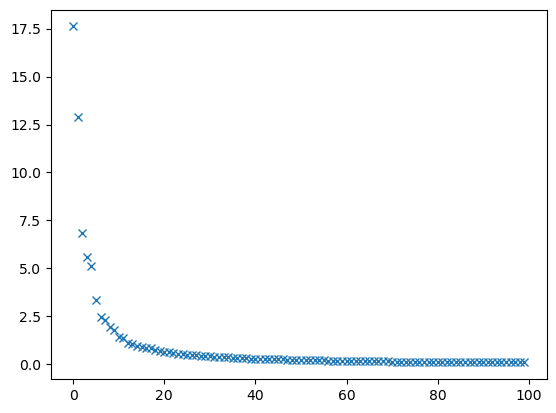

In [22]:
#Plot variance explained by each eigenface
plt.plot(variance_explained[0:100]*100, 'x')

2) Reconstruct a face.  How many EOFs do you need to reconstruct a face from the database?  Does it depend on the face that it used?

In [68]:
i

0

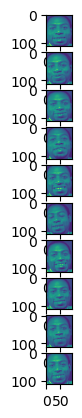

In [74]:
f, ax = plt.subplots(10,1)
for i, j in enumerate(range(206, 216,1)):
    ax[i].imshow(att_faces[:, :, j])

(400, 400)
(112, 92)


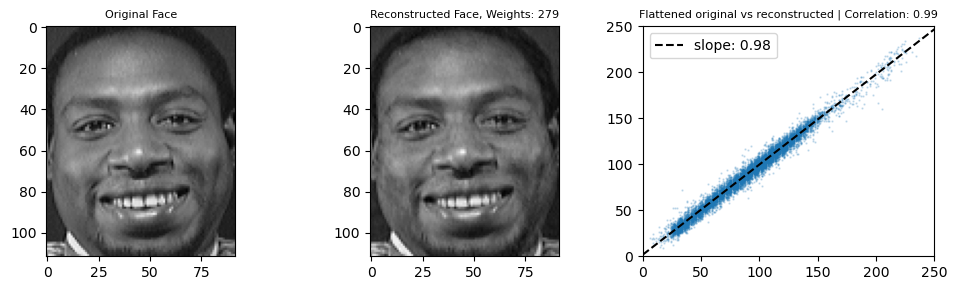

In [133]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', c='k', label='slope: ' + str(round(slope,2)))

#project the faces onto the eigenfaces
weights = np.dot(anomaly_matrix, eofs)
print(weights.shape)

#choose a face to reconstruct
face_num = 210 #0 to 389
original_face = att_faces[:, :, face_num]

for i, weight in enumerate(np.arange(0,401,1)):
    #choose number of weights to reconstruct face
    weights_num = weight
    face_weights = weights[face_num, 0:weights_num]
#     print(face_weights.shape)
    reconstructed_face = np.dot(eofs[:, 0:weights_num], face_weights)

    #At this point, the reconstructed face is an anomaly face with the average face removed. 
    #Add back the average face to get the original face
    reconstructed_face = np.reshape(reconstructed_face, (height, width)) + average_face
    
    og = xr.DataArray(original_face, dims=['x','y'])
    new = xr.DataArray(reconstructed_face, dims=['x','y'])
    if xr.corr(og, new).values >= 0.99:
        correlation=xr.corr(og, new).values
        slope, intercept, r_value, p_value, std_err = stats.linregress(original_face.flatten(), reconstructed_face.flatten())
        break
    
print(reconstructed_face.shape)
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].imshow(original_face, cmap='gray');
axs[0].set_title('Original Face', size=8)

axs[1].imshow(reconstructed_face, cmap='gray');
axs[1].set_title('Reconstructed Face, Weights: ' + str(weight), size=8)

axs[2].scatter(original_face.flatten(), reconstructed_face.flatten(), s=0.5, alpha=0.2)
axs[2].set_xlim(0,250)
axs[2].set_ylim(0,250)
axs[2].set_title('Flattened original vs reconstructed | Correlation: ' + str(round(r_value,2)), size=8)
abline(slope, intercept, axs[2])
axs[2].legend()
fig.tight_layout()



(400, 400)
(112, 92)


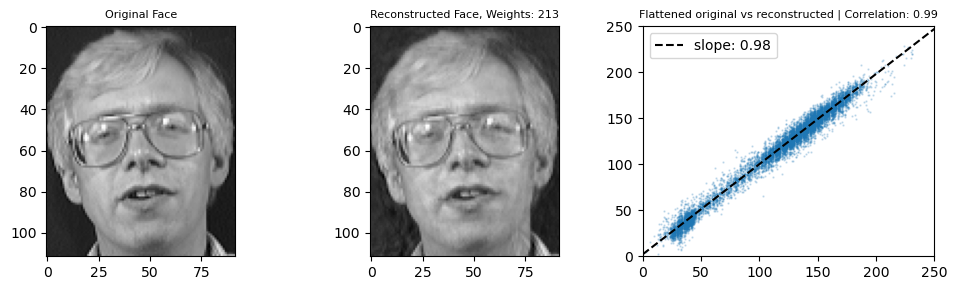

In [132]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', c='k', label='slope: ' + str(round(slope,2)))

#project the faces onto the eigenfaces
weights = np.dot(anomaly_matrix, eofs)
print(weights.shape)

#choose a face to reconstruct
face_num = 10 #0 to 389
original_face = att_faces[:, :, face_num]

for i, weight in enumerate(np.arange(0,401,1)):
    #choose number of weights to reconstruct face
    weights_num = weight
    face_weights = weights[face_num, 0:weights_num]
#     print(face_weights.shape)
    reconstructed_face = np.dot(eofs[:, 0:weights_num], face_weights)

    #At this point, the reconstructed face is an anomaly face with the average face removed. 
    #Add back the average face to get the original face
    reconstructed_face = np.reshape(reconstructed_face, (height, width)) + average_face
    
    og = xr.DataArray(original_face, dims=['x','y'])
    new = xr.DataArray(reconstructed_face, dims=['x','y'])
    if xr.corr(og, new).values >= 0.99:
        correlation=xr.corr(og, new).values
        slope, intercept, r_value, p_value, std_err = stats.linregress(original_face.flatten(), reconstructed_face.flatten())
        break
    
print(reconstructed_face.shape)
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].imshow(original_face, cmap='gray');
axs[0].set_title('Original Face', size=8)

axs[1].imshow(reconstructed_face, cmap='gray');
axs[1].set_title('Reconstructed Face, Weights: ' + str(weight), size=8)

axs[2].scatter(original_face.flatten(), reconstructed_face.flatten(), s=0.5, alpha=0.2)
axs[2].set_xlim(0,250)
axs[2].set_ylim(0,250)
axs[2].set_title('Flattened original vs reconstructed | Correlation: ' + str(round(r_value,2)), size=8)
abline(slope, intercept, axs[2])
axs[2].legend()
fig.tight_layout()



(400, 400)
(112, 92)


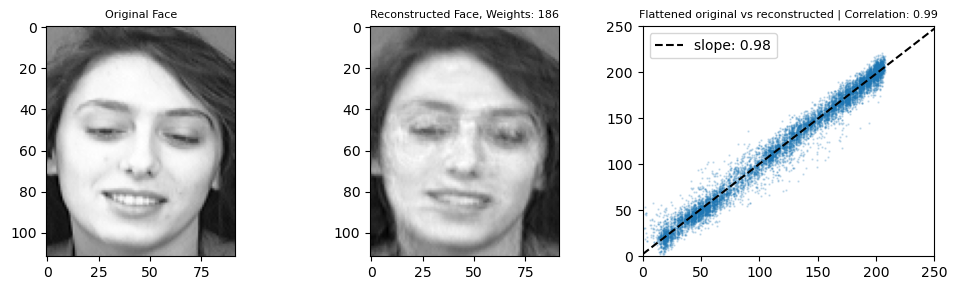

In [131]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', c='k', label='slope: ' + str(round(slope,2)))

#project the faces onto the eigenfaces
weights = np.dot(anomaly_matrix, eofs)
print(weights.shape)

#choose a face to reconstruct
face_num = 70 #0 to 389
original_face = att_faces[:, :, face_num]

for i, weight in enumerate(np.arange(0,401,1)):
    #choose number of weights to reconstruct face
    weights_num = weight
    face_weights = weights[face_num, 0:weights_num]
#     print(face_weights.shape)
    reconstructed_face = np.dot(eofs[:, 0:weights_num], face_weights)

    #At this point, the reconstructed face is an anomaly face with the average face removed. 
    #Add back the average face to get the original face
    reconstructed_face = np.reshape(reconstructed_face, (height, width)) + average_face
    
    og = xr.DataArray(original_face, dims=['x','y'])
    new = xr.DataArray(reconstructed_face, dims=['x','y'])
    if xr.corr(og, new).values >= 0.99:
        correlation=xr.corr(og, new).values
        slope, intercept, r_value, p_value, std_err = stats.linregress(original_face.flatten(), reconstructed_face.flatten())
        
        break
    
print(reconstructed_face.shape)
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].imshow(original_face, cmap='gray');
axs[0].set_title('Original Face', size=8)

axs[1].imshow(reconstructed_face, cmap='gray');
axs[1].set_title('Reconstructed Face, Weights: ' + str(weight), size=8)

axs[2].scatter(original_face.flatten(), reconstructed_face.flatten(), s=0.5, alpha=0.2)
axs[2].set_xlim(0,250)
axs[2].set_ylim(0,250)
axs[2].set_title('Flattened original vs reconstructed | Correlation: ' + str(round(r_value,2)), size=8)
abline(slope, intercept, axs[2])
axs[2].legend()
fig.tight_layout()

